# Radiative Equilibrium

This notebook is a slightly modified chapter of the excellent [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

NOTE: from v0.8 of climlab the fortran extensions need to be compiled separately.  I found the best way to do this was to switch to using a conda environment, which I did by using mamba, which is much faster. 



## 1. The observed annual, global mean temperature profile
____________

Let's look at the observations of air temperature from the NCEP Reanalysis data.

In this notebook  we'll define a function to create the Skew-T diagram, because later we are going to reuse it several times.

*Click to expand code cells to see Python details* 

In [66]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT

# tompkins additional packages
#from cdo import Cdo
#import cdsapi
from netCDF4 import Dataset
#


import requests
import os


In [67]:
# Note: Ensure the URL points to the actual .nc file download
url = "http://clima-dods.ictp.it/Users/tompkins/diploma/data/"
files=["tmean3.nc","qvmean3.nc"]
target="../data/"
for file in files:
    # 2. Download the file if it doesn't exist on your disk yet
    if not os.path.exists(target+file):
        print(f"Downloading {file}...")
        r = requests.get(url+file, stream=True)
        r.raise_for_status()
        with open(target+file, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print("Files present")



Files present
Files present


In [68]:
if True:
    ds = xr.open_dataset(target+"tmean3.nc", use_cftime=True)
    Tglobal=ds.air
    ds = xr.open_dataset(target+"qvmean3.nc", use_cftime=True)
    Qglobal=ds.q

In [2]:
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
#file="pressure/air.mon.1981-2010.ltm.nc"
if False:
    ncep_url = "http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/Monthlies/"
    file="pressure/air.mon.ltm.1981-2010.nc"
    
    ncep_air = xr.open_dataset( ncep_url + file, use_cftime=True)
    #  Take global, annual average 
    coslat = np.cos(np.deg2rad(ncep_air.lat))
    weight = coslat / coslat.mean(dim='lat')
    Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [69]:
def make_skewT():
    fig = plt.figure(figsize=(6, 6))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

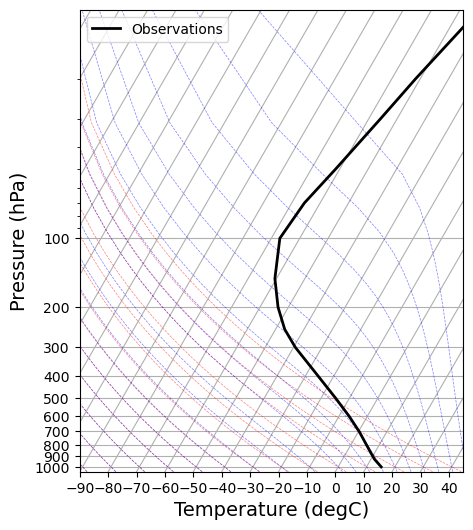

In [70]:
skew = make_skewT()

Here we are going to work with some detailed **Single-Column Models** to understand questions such as

- What physical factors actually determine this profile? 
- Would the profile be different with different gases in the atmosphere?
- What are the relative roles of **radiation** and **dynamics** (i.e. motion!) in setting this profile?

We will start by **ignoring all processes except radiation**. We will calculate something called the **radiative equilibrium** temperature.


## 2. Radiative equilibrium -- the concept


Models of radiative transfer slice up the atmospheric air column into a series of layer, and calculate the **emission** and **absorption** of radiation within each layer.

It's really just a generalization of the model we already looked at:

<div>
<img src="http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/2layerAtm_sketch.png" width="700"/>
</div>

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

We can answer that question by using a radiative transfer model to explicity compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.

Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will **use a model** that represents these processes at the same level of detail we would in a GCM.


## 3. Setting up a single-column radiation model in climlab


### Radiation models in climlab

We're now going to use **climlab** to run a **complex radiation model**, one that accounts for the spectral absorption properties of different gases.

climlab actually provides two different "GCM-level" [radiation codes](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html):

- The [CAM3 radiation module](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.CAM3.html) from NCAR (essentially the same radiation code used in our CESM simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

climlab provides an easy-to-use Python wrapper for the RRTMG code.

### Water vapor data

Before setting up the model, we need some water vapor data. Why? Because our model needs to know how much water vapor exists at each vertical level, since water vapor is a radiatively important gas.

We're going to use the specific humidity from the ERA5 reanalysis, we will just take a single monthly average as a starting point. First We'll just take the global, time average of this data, and plot its vertical profile.

first the retrieval:

Now take the global, annual average of the specific humidity:

And make a figure:

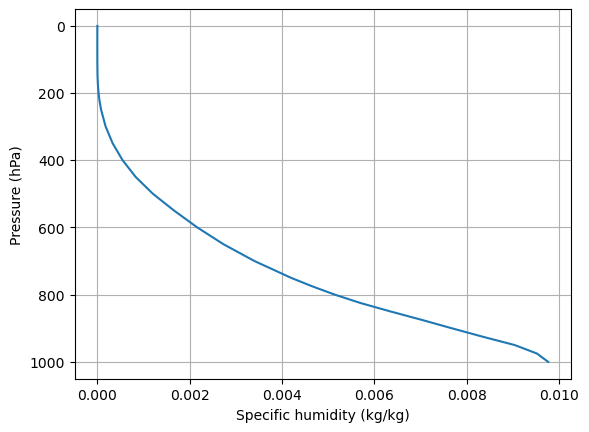

In [71]:
fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal, Qglobal.level)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (kg/kg)')
ax.grid()

This shows a typical climatological humidity profile. Water vapor is a **trace gas**! But as we will see, it plays a very important role.

Based on this figure, where is most of the water vapor?

### Create a single-column model on the same grid as this water vapor data:

Here we will create the grid and state variables (air and surface temperature) for our single-column model.

In [72]:
import climlab
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.level, water_depth=2.5)
print(mystate)

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.16666667, 204.33333333, 206.5       ,
       208.66666667, 210.83333333, 213.        , 215.16666667,
       217.33333333, 219.5       , 221.66666667, 223.83333333,
       226.        , 228.16666667, 230.33333333, 232.5       ,
       234.66666667, 236.83333333, 239.        , 241.16666667,
       243.33333333, 245.5       , 247.66666667, 249.83333333,
       252.        , 254.16666667, 256.33333333, 258.5       ,
       260.66666667, 262.83333333, 265.        , 267.16666667,
       269.33333333, 271.5       , 273.66666667, 275.83333333,
       278.        ])})


In [73]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
print(radmodel)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (37,) 
The subprocess tree: 
Radiation (all gases): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



### Explore the single-column model object

Look at a few interesting properties of the model we just created:

In [74]:
#  Here's the state dictionary we already created:
radmodel

In [75]:
#  Here are the pressure levels in hPa
radmodel.lev

array([   1.,    2.,    3.,    5.,    7.,   10.,   20.,   30.,   50.,
         70.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,  300.,
        350.,  400.,  450.,  500.,  550.,  600.,  650.,  700.,  750.,
        775.,  800.,  825.,  850.,  875.,  900.,  925.,  950.,  975.,
       1000.])

There is a dictionary called `absorber_vmr` that holds the *volume mixing ratio* of all the radiatively active gases in the column:

In [76]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([3.32452359e-06, 5.49765445e-06, 7.03108249e-06, 8.17280656e-06,
        8.49624970e-06, 8.49933725e-06, 6.47842360e-06, 4.48576690e-06,
        2.25137178e-06, 1.13532298e-06, 5.32009049e-07, 3.46334801e-07,
        2.45552383e-07, 1.90806332e-07, 1.51755709e-07, 1.19700066e-07,
        9.29020109e-08, 6.59109748e-08, 5.57122567e-08, 5.02096369e-08,
        4.60528063e-08, 4.29407799e-08, 4.08899052e-08, 3.91554265e-08,
        3.76122833e-08, 3.54532697e-08, 3.31238355e-08, 3.18505117e-08,
        3.05754534e-08, 2.93003951e-08, 2.80298557e-08, 2.69906527e-08,
        2.59514497e-08, 2.49122466e-08, 2.38730436e-08, 2.28798533e-08,
        2.19124599e-08])}

Most are just a single number because they are assumed to be **well mixed** in the atmosphere.

In [77]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
radmodel.absorber_vmr['CO2'] * 1E6

348.0

### Python exercise: plot the ozone profile

The exception is ozone, which has a vertical structure taken from observations. Let's plot it!  Make a simple plot showing the vertical structure of ozone, similar to the specific humidity plot we just made above.

[   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]
[3.32452359e-06 5.49765445e-06 7.03108249e-06 8.17280656e-06
 8.49624970e-06 8.49933725e-06 6.47842360e-06 4.48576690e-06
 2.25137178e-06 1.13532298e-06 5.32009049e-07 3.46334801e-07
 2.45552383e-07 1.90806332e-07 1.51755709e-07 1.19700066e-07
 9.29020109e-08 6.59109748e-08 5.57122567e-08 5.02096369e-08
 4.60528063e-08 4.29407799e-08 4.08899052e-08 3.91554265e-08
 3.76122833e-08 3.54532697e-08 3.31238355e-08 3.18505117e-08
 3.05754534e-08 2.93003951e-08 2.80298557e-08 2.69906527e-08
 2.59514497e-08 2.49122466e-08 2.38730436e-08 2.28798533e-08
 2.19124599e-08]


Text(0.5, 0, 'Ozone')

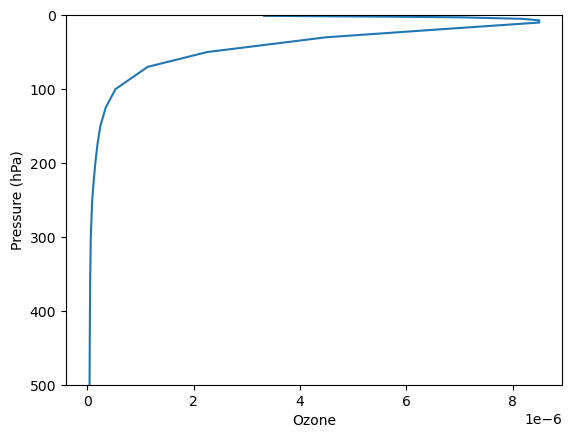

In [80]:
# here is the data you need for the plot, as a plain numpy arrays:
print(radmodel.lev)
print(radmodel.absorber_vmr['O3'])
fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(radmodel.absorber_vmr['O3'], Qglobal.level)
ax.invert_yaxis()
ax.set_ylim([500,0])
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Ozone')

The other radiatively important gas is of course water vapor, which is stored separately in the `specific_humidity` attribute:

In [81]:
#  specific humidity in kg/kg, on the same pressure axis
print(radmodel.specific_humidity)

[3.8457347e-06 3.6493720e-06 3.5112321e-06 3.3572430e-06 3.2921080e-06
 3.1566631e-06 2.9827183e-06 2.8756310e-06 2.7204785e-06 2.8124150e-06
 3.1334841e-06 4.1708249e-06 7.2928692e-06 1.4667128e-05 2.8827899e-05
 5.1621642e-05 8.4014886e-05 1.8216367e-04 3.3466466e-04 5.4847193e-04
 8.3233468e-04 1.2052541e-03 1.6642383e-03 2.1651143e-03 2.7329151e-03
 3.4037135e-03 4.1971849e-03 4.6512000e-03 5.1446785e-03 5.7034940e-03
 6.3512409e-03 7.0269099e-03 7.6783136e-03 8.3446391e-03 9.0420889e-03
 9.5190788e-03 9.7642774e-03]


### The RRTMG radiation model has lots of different input parameters

For details you can look at the [documentation](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.radiation.html)

In [82]:
for item in radmodel.input:
    print(item)

specific_humidity
absorber_vmr
cldfrac
clwp
ciwp
r_liq
r_ice
emissivity
S0
insolation
coszen
eccentricity_factor
aldif
aldir
asdif
asdir
icld
irng
idrv
permuteseed_sw
permuteseed_lw
dyofyr
inflgsw
inflglw
iceflgsw
iceflglw
liqflgsw
liqflglw
tauc_sw
tauc_lw
ssac_sw
asmc_sw
fsfc_sw
tauaer_sw
ssaaer_sw
asmaer_sw
ecaer_sw
tauaer_lw
isolvar
indsolvar
bndsolvar
solcycfrac


Many of the parameters control the **radiative effects of clouds**.

But here we should note that the model is **initialized with no clouds at all**:

In [83]:
#  This is the fractional area covered by clouds in our column:
radmodel.cldfrac

0.0



## 4. Radiative equilibrium in the single-column model


### Step the model forward in time!

Here are the current temperatures (initial condition):

In [84]:
radmodel.Ts

Field([288.])

In [85]:
radmodel.Tatm


Field([200.        , 202.16666667, 204.33333333, 206.5       ,
       208.66666667, 210.83333333, 213.        , 215.16666667,
       217.33333333, 219.5       , 221.66666667, 223.83333333,
       226.        , 228.16666667, 230.33333333, 232.5       ,
       234.66666667, 236.83333333, 239.        , 241.16666667,
       243.33333333, 245.5       , 247.66666667, 249.83333333,
       252.        , 254.16666667, 256.33333333, 258.5       ,
       260.66666667, 262.83333333, 265.        , 267.16666667,
       269.33333333, 271.5       , 273.66666667, 275.83333333,
       278.        ])

Now let's take a single timestep:

In [86]:
radmodel.step_forward()


In [87]:
radmodel.Ts

Field([288.55189003])

The surface got warmer! 

Let's take a look at all the diagnostic information that was generated during that timestep:

### Diagnostic variables in our single-column model

Every climlab model has a `diagnostics` dictionary. Here we are going to check it out as an `xarray` dataset:

In [88]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset> Size: 6kB
Dimensions:           (depth: 1, lev: 37, lev_bounds: 38, depth_bounds: 2)
Coordinates:
  * depth             (depth) float64 8B 1.25
  * lev               (lev) float64 296B 1.0 2.0 3.0 5.0 ... 950.0 975.0 1e+03
  * depth_bounds      (depth_bounds) float64 16B 0.0 2.5
  * lev_bounds        (lev_bounds) float64 304B 0.0 1.5 2.5 ... 987.5 1e+03
Data variables: (12/26)
    OLR               (depth) float64 8B 233.2
    OLRclr            (depth) float64 8B 233.2
    OLRcld            (depth) float64 8B 0.0
    TdotLW            (lev) float64 296B -1.956 -1.489 ... -0.004821 3.397
    TdotLW_clr        (lev) float64 296B -1.956 -1.489 ... -0.004821 3.397
    LW_sfc            (depth) float64 8B 96.79
    ...                ...
    SW_flux_up        (lev_bounds) float64 304B 86.48 86.4 86.36 ... 54.73 54.52
    SW_flux_down      (lev_bounds) float64 304B 341.3 338.6 ... 219.4 218.1
    SW_flux_net       (lev_bounds) float64 304B 254.8 252.2 ... 164.6 163.6
    SW_flux_up_clr    (lev_bounds) float64 304B 86.48 86.4 86.36 ... 54.73 54.52
    SW_flux_down_clr  (lev_bounds) float64 304B 341.3 338.6 ... 219.4 218.1
    SW_flux_net_clr   (lev_bounds) float64 304B 254.8 252.2 ... 164.6 163.6

The main "job" of a radiative transfer model it to calculate the shortwave and longwave fluxes up and down between each model layer.

For example:

In [89]:
climlab.to_xarray(radmodel.LW_flux_up)

<xarray.DataArray (lev_bounds: 38)> Size: 304B
Field([233.23147847, 233.27096996, 233.31757654, 233.39620223,
       233.52259998, 233.68507349, 234.1055069 , 234.86667679,
       236.01139724, 237.37921847, 238.83504419, 240.27003898,
       241.54307065, 242.81358937, 244.11917082, 245.49779143,
       246.88847813, 248.68672214, 251.19192794, 254.03921072,
       257.24838074, 260.82848989, 264.82718237, 269.31786903,
       274.33012794, 279.98518765, 286.68635903, 293.67397263,
       299.63963686, 305.87261782, 312.39847031, 319.27513908,
       326.52903585, 334.17666059, 342.30872826, 351.31763509,
       363.30677695, 390.099014  ])
Coordinates:
  * lev_bounds  (lev_bounds) float64 304B 0.0 1.5 2.5 4.0 ... 962.5 987.5 1e+03

These are upward longwave fluxes in W/m2.

Why are there 38 data points, when the model has 37 pressure levels?

In [90]:
radmodel.lev

array([   1.,    2.,    3.,    5.,    7.,   10.,   20.,   30.,   50.,
         70.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,  300.,
        350.,  400.,  450.,  500.,  550.,  600.,  650.,  700.,  750.,
        775.,  800.,  825.,  850.,  875.,  900.,  925.,  950.,  975.,
       1000.])

In [91]:
radmodel.lev_bounds

array([   0. ,    1.5,    2.5,    4. ,    6. ,    8.5,   15. ,   25. ,
         40. ,   60. ,   85. ,  112.5,  137.5,  162.5,  187.5,  212.5,
        237.5,  275. ,  325. ,  375. ,  425. ,  475. ,  525. ,  575. ,
        625. ,  675. ,  725. ,  762.5,  787.5,  812.5,  837.5,  862.5,
        887.5,  912.5,  937.5,  962.5,  987.5, 1000. ])

The last element of the flux array represents the **upward flux from the surface to the first level**:

In [92]:
radmodel.LW_flux_up[-1]

390.0990139978321

The value is about 390 W m$^{-2}$. 

Why?

In [93]:
sigma = 5.67E-8
sigma * 288**4

390.0793946112

The surface temperature was initialized at 288 K, and the surface is treated as very close to a blackbody in the model.

What about the flux from the top layer out to space?

Two ways to access this information:

In [94]:
radmodel.LW_flux_up[0]

233.23147846618144

In [95]:
radmodel.OLR

Field([233.23147847])

Of course there is a whole other set of fluxes for the shortwave radiation.

One diagnostic we will often want to look at is the **net energy budget at the top of the atmosphere**:

In [96]:
radmodel.ASR - radmodel.OLR

Field([21.58976152])

***Is the model gaining or losing energy?***

### Integrate out to equilibrium

Here I want to step forward in time until the model is very close to energy balance.

We can use a `while` loop, conditional on the top-of-atmosphere imbalance:

In [97]:
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

Check the energy budget again:

In [98]:
#  Check the energy budget again
radmodel.ASR - radmodel.OLR

Field([0.00993646])

Indeed, the imbalance is now small.

### Compare the radiative equilibrium temperature to observations

Here's a helper function we'll use to add model temperature profiles to our skew-T plot:

In [99]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

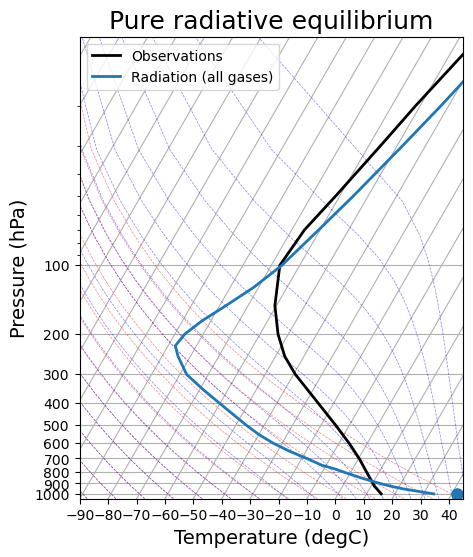

In [100]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

In [101]:
Tglobal

<xarray.DataArray 'air' (level: 17)> Size: 68B
array([ 15.172228,  11.20082 ,   7.832077,   0.213996,  -6.452575, -14.892839,
       -25.574112, -39.37232 , -46.79957 , -53.65291 , -60.56344 , -67.005264,
       -65.53255 , -61.486862, -55.85448 , -51.59509 , -43.221195],
      dtype=float32)
Coordinates:
  * level    (level) float32 68B 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
Attributes:
    long_name:     Monthly Long Term Mean of Air temperature
    units:         degC
    cell_methods:  time: mean time, lat, lon: mean
    precision:     2
    var_desc:      Air Temperature
    level_desc:    Pressure Levels
    statistic:     Long Term Mean
    parent_stat:   Mean
    actual_range:  [-89.722336  41.616005]
    dataset:       NCEP Reanalysis Derived Products

What do you think about this model -- data comparison?


## 5. Effects of different gases on the radiative equilibrium profile

---

**Models are for experimenting and playing with!**

We have just built a single-column radiation model with several different absorbing gases. *We can learn about their effects by taking them away.*

### Radiative equilibrium without water vapor

In [102]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
radmodel_noH2O.name = 'Radiation (no H2O)'
print(radmodel_noH2O)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (37,) 
The subprocess tree: 
Radiation (no H2O): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [103]:
#  Here is the water vapor profile we started with
radmodel_noH2O.specific_humidity

array([3.8457347e-06, 3.6493720e-06, 3.5112321e-06, 3.3572430e-06,
       3.2921080e-06, 3.1566631e-06, 2.9827183e-06, 2.8756310e-06,
       2.7204785e-06, 2.8124150e-06, 3.1334841e-06, 4.1708249e-06,
       7.2928692e-06, 1.4667128e-05, 2.8827899e-05, 5.1621642e-05,
       8.4014886e-05, 1.8216367e-04, 3.3466466e-04, 5.4847193e-04,
       8.3233468e-04, 1.2052541e-03, 1.6642383e-03, 2.1651143e-03,
       2.7329151e-03, 3.4037135e-03, 4.1971849e-03, 4.6512000e-03,
       5.1446785e-03, 5.7034940e-03, 6.3512409e-03, 7.0269099e-03,
       7.6783136e-03, 8.3446391e-03, 9.0420889e-03, 9.5190788e-03,
       9.7642774e-03], dtype=float32)

Now get rid of the water entirely!

In [104]:
radmodel_noH2O.specific_humidity *= 0.

In [105]:
radmodel_noH2O.specific_humidity

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

And run this new model forward to equilibrium:

In [106]:
#  it's useful to take a single step first before starting the while loop
#   because the diagnostics won't get updated 
#  (and thus show the effects of removing water vapor)
#  until we take a step forward
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

In [107]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-0.00998614])

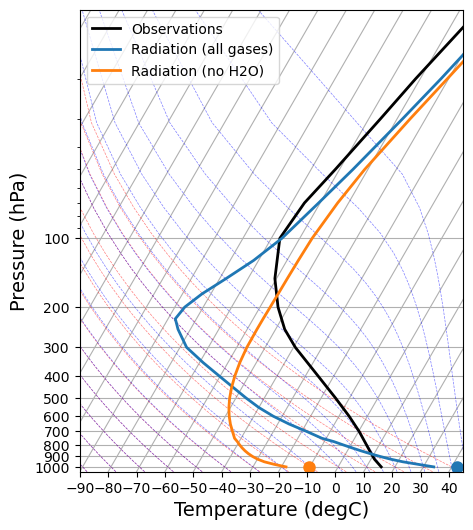

In [108]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

What do you think you can learn from this about the radiative role of water vapor?

### Exercise: radiative equilibrium without ozone

Following the steps above, make another model, but this time instead of removing the water vapor, remove the ozone!

Make another skew-T plot comparing all three model results.

If you have time, try a third case in which you remove both the water vapor and the ozone!


## 6. Summary of radiative equilibrium results

---


- We used the `RRTMG` radiation model with prescribed profiles of absorbing gases to calculate **pure radiative equilibrium** temperature profiles.
- Radiative Equilibriu means the temperatures that the surface and air column would have **if radiation was the only physical process that could transfer energy between levels**.
- We computed several different radiative equilibrium profiles, with and without key absorbing gases
    - The profile without water vapor is **much colder at surface and lower troposphere**, but about the same in the stratosphere
    - The profile without ozone is **much colder in the stratosphere**, but about the same near the surface.
    - In fact there really isn't a stratosphere at all without ozone! The temperature is nearly isothermal in the upper atmosphere in that profile.

However the really key takeaway message is that **none of these radiative equilibrium profiles look much like the observations in the troposphere**.

This strongly suggests that other physical processes (aside from radiation) are important in determining the observed temperature profile.

Plotting on the skew-T diagram makes it clear that **all the radiative equilibrium profiles are statically unstable near the surface**.

The next step is therefore to look at the effects of convective mixing on the temperatures of the surface and lower troposphere.



## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
